In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
peak_folder = '/Users/emiliebertholet/cernbox/coldbox_data/selected_waveforms'

with open(f'{peak_folder}/selection_cosmics_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
cosmics = pd.DataFrame(dic)
print(f"cosmics:  {cosmics.shape[0]} peaks, {cosmics.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS = pd.DataFrame(dic)
print(f"PNS:  {PNS.shape[0]} peaks, {PNS.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_neutrons_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_neutrons = pd.DataFrame(dic)
print(f"PNS_neutrons:  {PNS_neutrons.shape[0]} peaks, {PNS_neutrons.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_SideBand_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_SB = pd.DataFrame(dic)
print(f"PNS_SB:  {PNS_SB.shape[0]} peaks, {PNS_SB.trigger_record.unique().shape[0]} trigger records")


# cosmics, 25150 peaks, 4189 trigger records
# PNS, 46228 peaks, 14283 trigger records
# PNS_neutrons, 3780 peaks, 3187 trigger records
# PNS_SB, 39102 peaks, 13893 trigger records



# cosmics.keys()

cosmics:  25150 peaks, 4189 trigger records
PNS:  46228 peaks, 14283 trigger records
PNS_neutrons:  3780 peaks, 3187 trigger records
PNS_SB:  39102 peaks, 13893 trigger records


In [3]:
def pad_waveforms(input_data, pad_length=500):
    output_data = input_data
    output_data['waveform_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data['waveform']]
    return output_data

cosmics      = pad_waveforms(cosmics, 500)
PNS          = pad_waveforms(PNS, 500)
PNS_neutrons = pad_waveforms(PNS_neutrons, 500)
PNS_SB       = pad_waveforms(PNS_SB, 500)

In [4]:
train_percentage = 0.8
# tot_size = len( cosmics['waveform_padded'] )
# train_size = int( np.ceil(len( cosmics['waveform_padded'] )*train_percentage))

Ntot_cr = len( cosmics['waveform_padded'])
Ntot_pns = len( PNS_neutrons['waveform_padded'])
Ntrain_cr = int( np.ceil(len( cosmics['waveform_padded'] )*train_percentage))
Ntrain_pns = int( np.ceil(len( PNS_neutrons['waveform_padded'] )*train_percentage))

X_cr  = np.stack(cosmics['waveform_padded'][:Ntrain_cr])
X_pns = np.stack(PNS_neutrons['waveform_padded'][:Ntrain_pns])

X_cr_eval = np.stack(cosmics['waveform_padded'][Ntrain_cr:])
X_pns_eval = np.stack(PNS_neutrons['waveform_padded'][Ntrain_pns:])

print('Numner of events used in the traning')
print(f'y = 1: {Ntrain_cr}/{Ntot_cr}')
print(f'y = 1: {Ntrain_pns}/{Ntot_pns}')

# create labels: 0 for cosmics 1 for PNS
X = np.vstack([X_cr, X_pns])
Y = np.array([0] * len(X_cr) + [1] * len(X_pns))

Numner of events used in the traning
y = 1: 20120/25150
y = 1: 3024/3780


In [5]:
# Split train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))
print(len(Y_train), len(Y_test))

18515 4629
18515 4629


In [6]:
# Train
cls = GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=3,)
cls.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

In [12]:
# --- Evaluate ---
Y_pred = cls.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

# Optional: probabilities (useful for ROC curve or ranking)
y_prob = cls.predict_proba(X_test)[:, 1]

[[3990   34]
 [ 513   92]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4024
           1       0.73      0.15      0.25       605

    accuracy                           0.88      4629
   macro avg       0.81      0.57      0.59      4629
weighted avg       0.87      0.88      0.85      4629



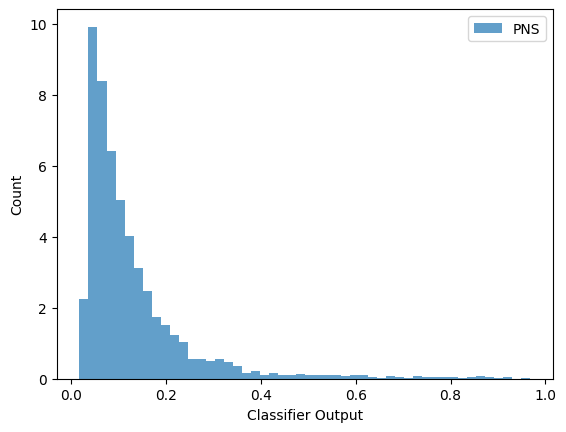

In [16]:
cls_output_pns = cls.predict_proba(X_test)[:, 1]  # Probability of class 1 (cr+n)

# Step 5: Visualize score distribution
plt.hist(cls_output_pns, bins=50, alpha=0.7, density=True, label='PNS')
# plt.hist(cls_output_cr, bins=50, alpha=0.7, density=True, label='cosmics')
# plt.title("Score Distribution for Signal+Noise Samples")
plt.xlabel("Classifier Output")
plt.ylabel("Count")
plt.legend()
plt.show()

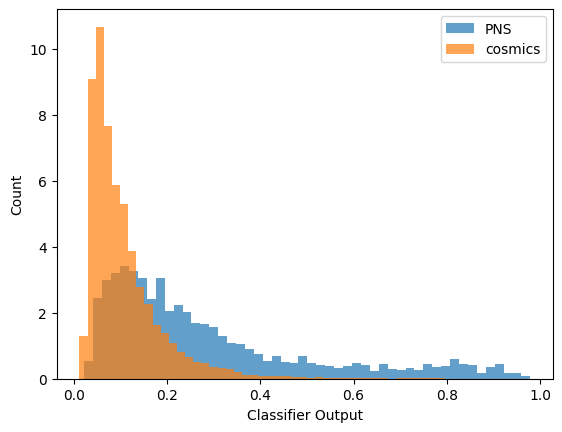

In [13]:
cls_output_pns = cls.predict_proba(X_pns)[:, 1]  # Probability of class 1 (cr+n)
cls_output_cr = cls.predict_proba(X_cr)[:, 1]  

# Step 5: Visualize score distribution
plt.hist(cls_output_pns, bins=50, alpha=0.7, density=True, label='PNS')
plt.hist(cls_output_cr, bins=50, alpha=0.7, density=True, label='cosmics')
# plt.title("Score Distribution for Signal+Noise Samples")
plt.xlabel("Classifier Output")
plt.ylabel("Count")
plt.legend()
plt.show()

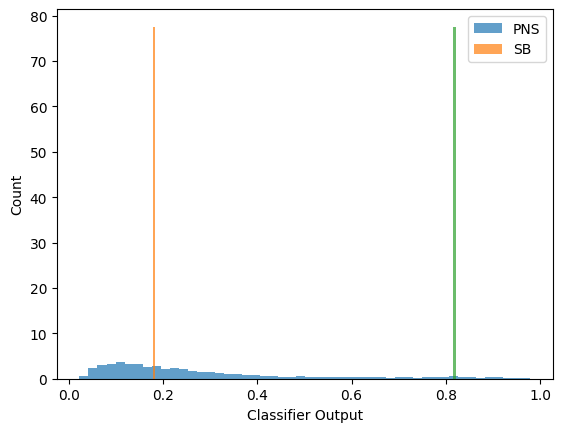

In [14]:
X1 =  np.stack( PNS_neutrons['waveform_padded'].values)
X2 =  np.stack( PNS_SB['waveform_padded'].values)

cls_output1 = cls.predict_proba(X1)[:, 1]  # Probability of class 1 (cr+n)
cls_output2 = cls.predict_proba(X2)[: 1]  

# Step 5: Visualize score distribution
plt.hist(cls_output1, bins=50, alpha=0.7, density=True, label='PNS')
plt.hist(cls_output2, bins=50, alpha=0.7, density=True, label='SB')
# plt.title("Score Distribution for Signal+Noise Samples")
plt.xlabel("Classifier Output")
plt.ylabel("Count")
plt.legend()
plt.show()

In [10]:
# # Optional: Rank samples by score
# top_signal_indices = np.argsort(cls_output)[::-1]
# top_signals = X_pns[top_signal_indices[:100]]  # Top 100 most "signal-like" samples